In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import json
import matplotlib.dates as mdates
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)
from pandas.io.json import json_normalize
from classify_campaigns import classify_campaigns 

import matplotlib.ticker as mtick
import matplotlib.dates as mdates

from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/daniel.ryu/.config/gcloud/application_default_credentials.json'
bigquery_client = bigquery.Client(project='apprec-prod')

In [4]:
exchange = pd.read_csv('~/Documents/appreciate/exchanges.csv')
imp_type = pd.read_csv('~/Documents/appreciate/imp_type.csv')
buyer = pd.read_csv('~/Documents/appreciate/buyer.csv')

In [18]:
wks = 6
end_dt = datetime.date.today() - datetime.timedelta(days = 1)
start_dt = datetime.date.today() - datetime.timedelta(weeks = wks)
# throttling on 9/12
print(start_dt, end_dt)

2021-08-17 2021-09-27


In [30]:
wks = 4
start_dt = '2021-08-17'
end_dt = (pd.to_datetime(start_dt) + datetime.timedelta(weeks = wks)).strftime('%Y-%m-%d')
print(start_dt, end_dt)

2021-08-17 2021-09-14


(1) DOW Install Volume (Based on revenue/Organic?) 

(2) Should budget be adjusted by DOW (more on the weekends vs/ weekdays)

In [6]:
def calc_metrics(df, sov_base = 0):
    df['win_rate'] = 100*df['impressions']/df['bids']
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['cost']/df['impressions']
    df['bpm'] = 1000*df['bid_price']/df['bids']
    df['rpi'] = df['revenue']/df['installs']
    df['profit'] = df['revenue']-df['cost']
    df['margin'] = 100*(df['profit'])/df['revenue']

    if sov_base == 0:
        df['cost_sov'] = 100*df['cost']/df['cost'].sum()
        df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
        df['total_cost'] = df['cost'].sum()
    else:
        df['cost_sov'] = 100*df['cost']/df.groupby(sov_base)['cost'].transform(sum)
        df['revenue_sov'] = 100*df['revenue']/df.groupby(sov_base)['revenue'].transform(sum)
        df['total_cost'] = df.groupby(sov_base)['cost'].transform(sum)
    return df[['bids','impressions','win_rate','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','revenue','revenue_sov','cost','cost_sov','profit','margin','total_cost']]

def calc_metrics2(df, sov_base = 0):
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['cost']/df['impressions']
    df['rpi'] = df['revenue']/df['installs']
    df['profit'] = df['revenue']-df['cost']
    df['margin'] = 100*(df['profit'])/df['revenue']

    if sov_base == 0:
        df['cost_sov'] = 100*df['cost']/df['cost'].sum()
        df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
        df['total_cost'] = df['cost'].sum()
    else:
        df['cost_sov'] = 100*df['cost']/df.groupby(sov_base)['cost'].transform(sum)
        df['revenue_sov'] = 100*df['revenue']/df.groupby(sov_base)['revenue'].transform(sum)
        df['total_cost'] = df.groupby(sov_base)['cost'].transform(sum)
    return df[['impressions','clicks','ctr','installs','ir','ipm','cpm','rpi','revenue','revenue_sov','cost','cost_sov','profit','margin','total_cost']]

def calc_metrics3(df, sov_base = 0):
    df['bid_rate'] = 100*df['bids']/df['bid_requests']
    df['win_rate'] = 100*df['impressions']/df['bids']
    df['ctr'] = 100*df['clicks']/df['impressions']
    df['ir'] = 100*df['installs']/df['clicks']
    df['ipm'] = 1000*df['installs']/df['impressions']
    df['cpm'] = 1000*df['cost']/df['impressions']
    df['bpm'] = 1000*df['bid_price']/df['bids']
    df['rpi'] = df['revenue']/df['installs']
    df['profit'] = df['revenue']-df['cost']
    df['margin'] = 100*(df['profit'])/df['revenue']

    if sov_base == 0:
        df['cost_sov'] = 100*df['cost']/df['cost'].sum()
        df['revenue_sov'] = 100*df['revenue']/df['revenue'].sum()
        df['total_cost'] = df['cost'].sum()
    else:
        df['cost_sov'] = 100*df['cost']/df.groupby(sov_base)['cost'].transform(sum)
        df['revenue_sov'] = 100*df['revenue']/df.groupby(sov_base)['revenue'].transform(sum)
        df['total_cost'] = df.groupby(sov_base)['cost'].transform(sum)
    return df[['bid_requests','bids','bid_rate','impressions','win_rate','clicks','ctr','installs','ir','ipm','bpm','cpm','rpi','revenue','revenue_sov','cost','cost_sov','profit','margin','total_cost']]

format_map = {'bid_requests':'{:,.0f}'
             ,'bids':'{:,.0f}'
             ,'impressions':'{:,.0f}'
             ,'clicks':'{:,.0f}'
             ,'installs':'{:,.0f}'
             ,'revenue':'${:,.0f}'
             ,'profit':'${:,.0f}'
             ,'cost':'${:,.0f}'
             ,'cpm':'${:,.2f}'
             ,'bpm':'${:,.2f}'
             ,'rpi':'${:,.2f}'
             ,'win_rate':'{:,.0f}%'
             ,'bid_rate':'{:,.0f}%'
             ,'ctr':'{:,.1f}%'
             ,'ir':'{:,.1f}%'
             ,'ipm':'{:,.2f}'
             ,'revenue_sov':'{:,.0f}%'
             ,'win_rate':'{:,.0f}%'
             ,'margin':'{:,.0f}%'
             ,'cost_sov':'{:,.0f}%'
             ,'bid_sov':'{:,.0f}%'
             ,'impression_sov':'{:,.0f}%'
             ,'cost_increase':'{:,.0f}%'
             ,'revenue_increase':'{:,.0f}%'}

In [7]:
df = bigquery_client.query(f"""
select
    date
    , date(etimestamp) as edate
    , extract(hour from timestamp) as hour
    , extract(dayofweek from timestamp) as dow
    , extract(dayofweek from etimestamp) as edow
    , c.name as campaign_name
    , r.ssb_campaign_uuid
    , sp.bundle as sponsored_bnd
    , sp.name as sponsored_app_name
    , left(r.ctr_model, length(r.ctr_model)-4) as model
    , case when r.ctr_model = 'production' then 'AP' else 'ML' end as model_type
    , r.ssb_buyer_id 
    , r.country
    , r.imp_type
    , r.exchange_id 
    , r.ad_type
    , count(case when event_type = 'clear' then 1 else NULL end)*16 as impressions
    , count(case when event_type = 'click' then 1 else NULL end)*16 as clicks
    , count(case when event_type = 'install' then 1 else NULL end)*16 as installs
    , sum(case when event_type = 'install' then revenue else 0 end)*16 as revenue
    , sum(case when event_type = 'clear' then settlement_price else 0 end)*16/1000 as cost
from stats.rows1 r
join metadata.campaigns c
    on r.ssb_campaign_uuid = c.uuid
join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
where 
    date >= '{start_dt}'
    and date <= '{end_dt}'
    and left(r.id,1) = '0'
group by 1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
""").to_dataframe()
df = df.set_index('imp_type').join(imp_type.set_index('imp_type_id')).reset_index()
df = df.set_index('exchange_id').join(exchange.set_index('exchange_id')).reset_index()
df['experience_type'] = df.apply(lambda x:classify_campaigns(x), axis = 1)
df

exchange_id  index        date       edate  hour  dow  edow  \
0                   1    1.0  2021-09-27  2021-09-28    23    2     3   
1                   1    1.0  2021-09-27  2021-09-28    23    2     3   
2                   1    1.0  2021-09-27  2021-09-28    23    2     3   
3                   1    1.0  2021-09-27  2021-09-28    22    2     3   
4                   1    1.0  2021-09-27  2021-09-28    23    2     3   
...               ...    ...         ...         ...   ...  ...   ...   
12338040           59   16.0  2021-09-27  2021-09-27    15    2     2   
12338041           59   16.0  2021-09-27  2021-09-27     0    2     2   
12338042           59   16.0  2021-09-27  2021-09-27     7    2     2   
12338043           59   16.0  2021-09-27  2021-09-27    20    2     2   
12338044           59   16.0  2021-09-27  2021-09-27     3    2     2   

                                           campaign_name  \
0                            Twitter - Twitter - BR - UA   
1                       Twitter - Twitter - BR - True GP   
2                        Android-Pandora-Pandora-US-5-AC   
3         Position Mobile - Weather Home - US - UA - VZW   
4                          Solitaire - Android - US - ST   
...                                                  ...   
12338040            Woodoku_android_Appreciate_DSP_Video   
12338041             Android-King-Candy Crush-US-4-Video   
12338042             Android-King-Candy Crush-US-4-Video   
12338043            Woodoku_android_Appreciate_DSP_Video   
12338044  US_EN_MAN_DigitalTurbine_Buyer_App_Android_DSP   

                         ssb_campaign_uuid               sponsored_bnd  ...  \
0         292906bbb71deaebb880439ce8c72995         com.twitter.android  ...   
1         b7c89cdb901658c9b5cde8b89203d0f0         com.twitter.android  ...   
2         28cab68e383d553e67cda191ce0d409d         com.pandora.android  ...   
3         f170d605138818f15d91db49b1bf498e      com.home.weather.radar  ...   
4         2c7f45e858f5529b3c1d70f858c38df2  com.mobilityware.solitaire  ...   
...                                    ...                         ...  ...   
12338040  712ae05eebe66b8d6902fa30c48059db       com.tripledot.woodoku  ...   
12338041  90cb602bccc5c39a93d6e3f23df5a44f     com.king.candycrushsaga  ...   
12338042  90cb602bccc5c39a93d6e3f23df5a44f     com.king.candycrushsaga  ...   
12338043  712ae05eebe66b8d6902fa30c48059db       com.tripledot.woodoku  ...   
12338044  377f7d215c7eea2215496d0876a616df      fr.vestiairecollective  ...   

         country ad_type impressions  clicks installs revenue      cost  \
0             BR  banner          16      16        0     0.0  0.005387   
1             BR   inter          16       0        0     0.0  0.018784   
2             US   inter         288      16       16    36.8  5.055468   
3             US   inter          16      16       48    88.8  1.123326   
4             US  banner          16       0        0     0.0  0.003315   
...          ...     ...         ...     ...      ...     ...       ...   
12338040      US   inter          16       0        0     0.0  0.244672   
12338041      US   inter         128      16        0     0.0  1.181360   
12338042      US   inter          16       0        0     0.0  0.052176   
12338043      US   inter         256      16        0     0.0  2.205408   
12338044      US   inter          16       0        0     0.0  0.041760   

          impression type  exchange_name  experience_type  
0                 display          Fyber                2  
1                 display          Fyber                4  
2                 display          Fyber               -1  
3                 display          Fyber                2  
4                 display          Fyber               -1  
...                   ...            ...              ...  
12338040   rewarded video        Samsung               -1  
12338041   rewarded video        Samsung                4  
12338042   rewarded vi

In [8]:
df_auctions_bids = bigquery_client.query(f"""
select
    date(r.t_created) as date
    , extract(dayofweek from date(r.t_created)) as dow
    , r.exchange_id
    , r.ad_type
    , r.country
    , sp.name as sponsored_app_name
    , sp.bundle as sponsored_bnd
    , r.imp_type
    , left(r.ctr_model, length(r.ctr_model)-4) as model
    , case when r.ctr_model = 'production' then 'AP' else 'ML' end as model_type
    , c.name as campaign_name
    , r.ssb_campaign_uuid
    , r.ssb_buyer_id 
    , sum(if(event_type = 'auction',1,0))*512 bid_requests
    , sum(if(event_type = 'bid',1,0))*32 bids
    , sum(if(event_type = 'bid',bid_price,0))/1000*32 as bid_price
from stats.auctions_bids r 
left join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
left join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
left join metadata.apps ho
    on r.hosting_app_id = ho.app_id
where 
    date(r.t_created) >= '{start_dt}'
    and date(r.t_created) <= '{end_dt}'
group by 1,2,3,4,5,6,7,8,9,10,11,12,13
""").to_dataframe()
df_auctions_bids = df_auctions_bids.set_index('imp_type').join(imp_type.set_index('imp_type_id')).reset_index()
df_auctions_bids = df_auctions_bids.set_index('exchange_id').join(exchange.set_index('exchange_id')).reset_index()
df_auctions_bids['experience_type'] = df_auctions_bids.apply(lambda x:classify_campaigns(x), axis = 1)

In [9]:
df_offers = bigquery_client.query(f"""
select
    *
from metadata.offers c
""").to_dataframe()
json_struct = df_offers['extra_data'].apply(json.loads)
df_offers_flat = pd.json_normalize(json_struct) 
df_offers_joined = df_offers.join(df_offers_flat)
df_offers_joined.drop(['extra_data'], axis = 1, inplace = True)
df_offers_joined.rename(columns = {'uuid':'ssb_offer_uuid', 'name':'offer_name','id':'offer_id'}, inplace = True)
df_campaigns = bigquery_client.query(f"""
select
    *
from metadata.campaigns c
""").to_dataframe()
json_struct = df_campaigns['extra_data'].apply(json.loads)
df_campaigns_flat = pd.json_normalize(json_struct) 
df_campaigns_joined = df_campaigns.join(df_campaigns_flat)
df_campaigns_joined.drop(['extra_data'], axis = 1, inplace = True)
df_campaigns_joined.rename(columns = {'uuid':'ssb_campaign_uuid', 'name':'campaign_name','id':'campaign_id'}, inplace = True)
df_campaigns_offers = pd.merge(df_campaigns_joined, df_offers_joined, how = 'left', on = ['ssb_buyer_id','offer_id'], suffixes = ['_campaign','_offer'])

In [10]:
df_campaigns_offers.loc[(df_campaigns_offers.status_campaign == 'normal') & (df_campaigns_offers.auto_pilot_cpi_factor>=1.5), ['campaign_name','ssb_campaign_uuid','campaign_id','auto_pilot_cpi_factor', 'mp_daily_installs', 'media_plan_daily_budget','enable_loss_tracking','clm_max_loss']]

campaign_name  \
36             OM Omantel Games iOS (320x480)   
41                 OM Omantel Kids iOS Banner   
44              OM Omantel Games iOS (320x50)   
479                  AZ Kids Azercell A Video   
1253             Android-Twitter-Twitter-AR-2   
...                                       ...   
13577         Android-Pandora-Pandora-US-5-AC   
13578            Android-Twitter-Twitter-US-5   
13583  Android-Amply Media-Breaking News-US-5   
14199             ZA_Cellc_Games_Multiproduct   
14202             ZA_Cellc_Games_Vikings Game   

                      ssb_campaign_uuid  campaign_id  auto_pilot_cpi_factor  \
36     1a1a74cb8f96927ae55f44acdc7470cf         1234                    1.5   
41     c21c47e184468dd90dd4ada678052233         1318                    1.5   
44     3ef5b0758f9729e694cb78288ed54d71         1400                    1.5   
479    82beb1e043ec0baa5e911112085f2b53         1280                    1.5   
1253   058d1b7ac105ca32cc5fe34b2cf3abb8          279                    1.5   
...                                 ...          ...                    ...   
13577  28cab68e383d553e67cda191ce0d409d          569                    2.0   
13578  92f918c60393afb48c6ee6af191b7eaf          570                    2.0   
13583  0fb3657f1961be41bbf20010c1232819          579                    2.5   
14199  2689c567e5fd0dcd4ab9c4865a04e8b4            1                    1.7   
14202  375e9be2fc8e96e7f5d02962c8cdd3c4            4                    1.7   

       mp_daily_installs  media_plan_daily_budget enable_loss_tracking  \
36                   NaN                    300.0                  NaN   
41                   NaN                    300.0                  NaN   
44                   NaN                    300.0                  NaN   
479                  NaN                     50.0                  NaN   
1253              2000.0                   2000.0                False   
...                  ...                      ...                  ...   
13577             2200.0                   8000.0                False   
13578             2100.0                   4000.0                False   
13583                NaN                   5000.0                False   
14199                NaN                    300.0                  NaN   
14202                NaN                    500.0                  NaN   

       clm_max_loss  
36              NaN  
41              NaN  
44              NaN  
479             NaN  
1253          200.0  
...             ...  
13577        2000.0  
13578        1000.0  
13583        4000.0  
14199           NaN  
14202           NaN  

[183 rows x 8 columns]

In [11]:
top_campaigns = df.groupby('campaign_name')['revenue'].sum().sort_values(ascending = False)[:100].index.tolist()

In [12]:
df_auctions_bids = df_auctions_bids.loc[(df_auctions_bids.date >= pd.to_datetime(start_dt)) & (df_auctions_bids.date <= pd.to_datetime(end_dt))]
df = df.loc[(df.date >= pd.to_datetime(start_dt)) & (df.date <= pd.to_datetime(end_dt))]


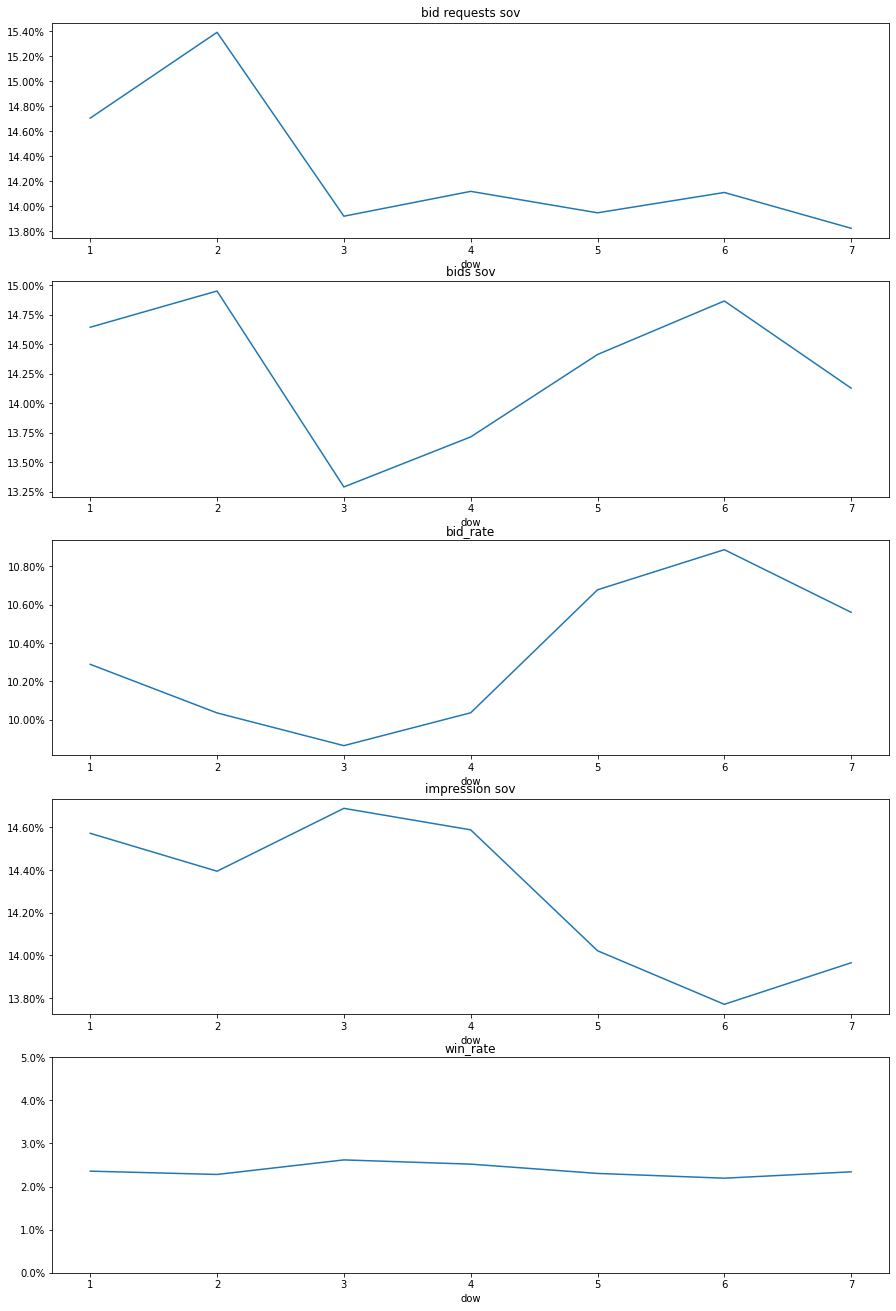

In [13]:
fig, ax = plt.subplots(5,1,figsize = (15,23))
pvt = df_auctions_bids.pivot_table(values = ['bid_requests','bids'], index = ['dow'], aggfunc = np.sum, margins = True)
pvt2 = df.pivot_table(values = ['impressions'], index = ['dow'], aggfunc = np.sum, margins = True)
pvt = pvt.join(pvt2)

sov_pvt = 100*pvt.div(pvt.iloc[-1]).iloc[:-1]
sov_pvt['bid_requests'].plot(title = 'bid requests sov', ax = ax[0], figure = fig)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
sov_pvt['bids'].plot(title = 'bids sov', ax = ax[1], figure = fig)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))

pvt['bid_rate'] = 100*pvt['bids']/pvt['bid_requests']
pvt.loc[:7,'bid_rate'].plot(title = 'bid_rate', ax = ax[2], figure = fig)
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
sov_pvt['impressions'].plot(title = 'impression sov', ax = ax[3], figure = fig)
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))

pvt['win_rate'] = 100*pvt['impressions']/pvt['bids']
pvt.loc[:7,'win_rate'].plot(title = 'win_rate', ax = ax[4], figure = fig)
ax[4].set_ylim(0,5)
ax[4].yaxis.set_major_formatter(mtick.PercentFormatter(100))

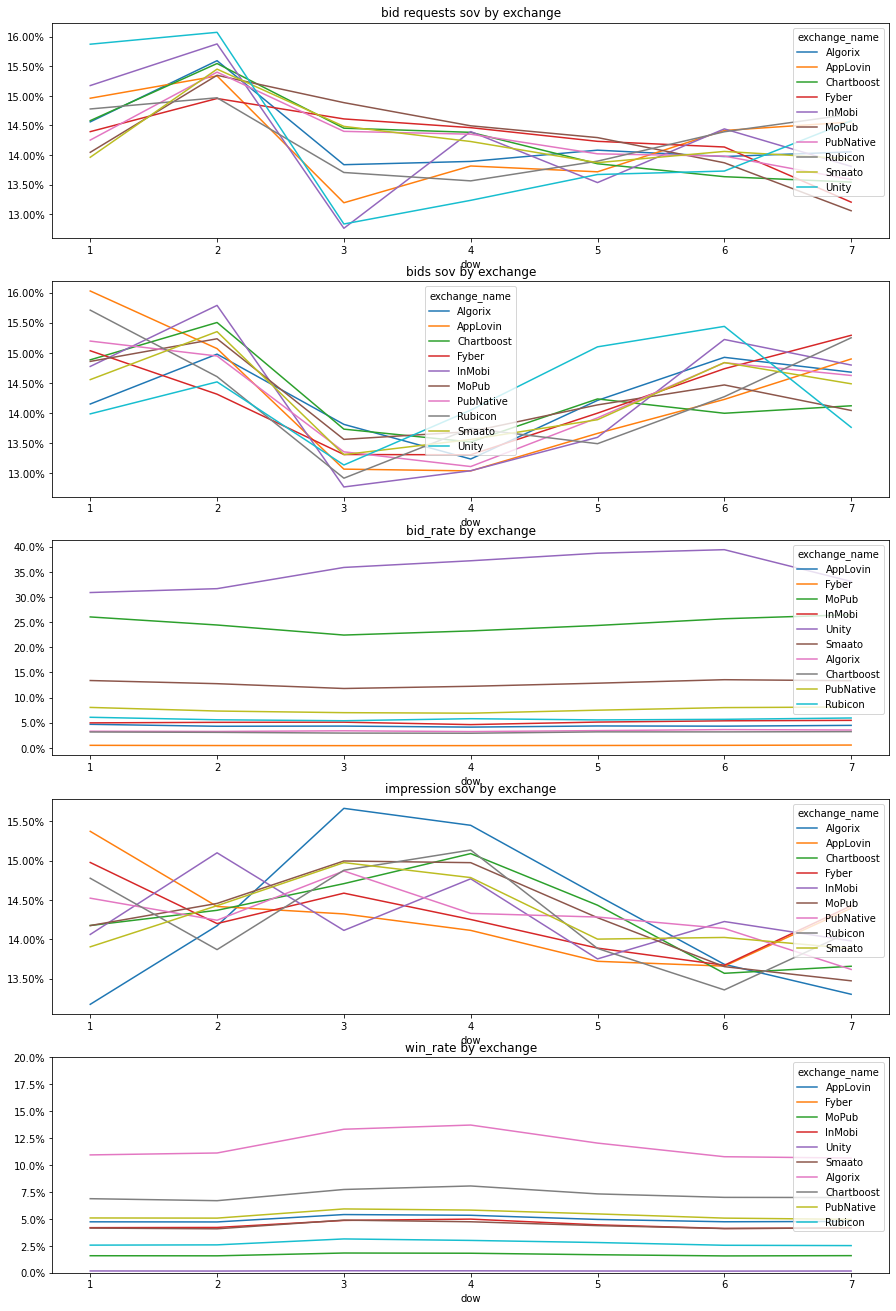

In [14]:
top_exchanges = df.groupby('exchange_name')['revenue'].sum().sort_values(ascending = False)[:10].index.tolist()

fig, ax = plt.subplots(5,1,figsize = (15,23))
pvt = df_auctions_bids[df_auctions_bids.exchange_name.isin(top_exchanges)].pivot_table(values = ['bid_requests','bids'], columns = ['exchange_name'], index = ['dow'], aggfunc = np.sum, margins = True)
pvt2 = df[df.exchange_name.isin(top_exchanges)].pivot_table(values = ['impressions'], index = ['dow'], columns = ['exchange_name'], aggfunc = np.sum, margins = True)
pvt = pvt.join(pvt2)
pvt = pvt.loc[:,pvt.columns[pvt.columns.get_level_values(1) != 'All']]

sov_pvt = 100*pvt.div(pvt.iloc[-1]).iloc[:-1,:-1]
sov_pvt['bid_requests'].plot(title = 'bid requests sov by exchange', ax = ax[0], figure = fig)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
sov_pvt['bids'].plot(title = 'bids sov by exchange', ax = ax[1], figure = fig)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))

for x in top_exchanges:
    pvt[('bid_rate', x)] = 100*pvt[('bids',x)]/pvt['bid_requests',x]
pvt.loc[:7,'bid_rate'].plot(title = 'bid_rate by exchange', ax = ax[2], figure = fig)
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))
sov_pvt['impressions'].plot(title = 'impression sov by exchange', ax = ax[3], figure = fig)
ax[3].yaxis.set_major_formatter(mtick.PercentFormatter(100))

for x in top_exchanges:
    pvt[('win_rate', x)] = 100*pvt[('impressions',x)]/pvt['bids',x]
pvt.loc[:7,'win_rate'].plot(title = 'win_rate by exchange', ax = ax[4], figure = fig)
ax[4].set_ylim(0,20)
ax[4].yaxis.set_major_formatter(mtick.PercentFormatter(100))

In [25]:
pivot = df_auctions_bids[df_auctions_bids.date >= pd.to_datetime(start_dt)].pivot_table(values = ['bid_requests','bids'], index = ['date','dow'], aggfunc = np.sum)
pivot

bid_requests        bids
date       dow                          
2021-08-17 3     69618442752  6470601056
2021-08-18 4     75775105536  6633889600
2021-08-19 5     72740401664  6418743872
2021-08-20 6     70827579392  6314637920
2021-08-21 7     72810091520  6417909760
2021-08-22 1     76365335552  6738796928
2021-08-23 2     70057829888  5823534176
2021-08-24 3     69909182464  4567159552
2021-08-25 4     67821786624  5768960288
2021-08-26 5     67220899840  6156891648
2021-08-27 6     70154897920  6171906848
2021-08-28 7     63658583552  5473723808
2021-08-29 1     73541471232  6522276160
2021-08-30 2     72774834688  6679669664
2021-08-31 3     74067358208  6624408768
2021-09-01 4     72211340288  6171432960
2021-09-02 5     72834728448  6442853504
2021-09-03 6     72073636864  6550135200
2021-09-04 7     70610110464  6602784000
2021-09-05 1     69933110784  6524685536
2021-09-06 2     71058922496  6728119104
2021-09-07 3     68784922112  6241941056
2021-09-08 4     69976934912  6052526144
2021-09-09 5     62867928576  5326577376
2021-09-10 6     64254279680  5322882272
2021-09-11 7     57932395520  3806935616
2021-09-12 1     64796146688  4421484608
2021-09-13 2     65006410240  5638917120
2021-09-14 3     63734316544  6499437280
2021-09-15 4     63459548672  6937128480
2021-09-16 5     65428651520  7264681760
2021-09-17 6     65719650304  7270185024
2021-09-18 7     66573092352  7696888192
2021-09-19 1     66799806976  7730731680
2021-09-20 2     64480523264  6925414656
2021-09-21 3     63614425088  7027509792
2021-09-22 4     66412954112  7391153792
2021-09-23 5     65601633792  7352754816
2021-09-24 6     62746481664  7155100800
2021-09-25 7     65448988672  6491298816
2021-09-26 1     71368960000  6044884320
2021-09-27 2     68581216768  5704928032

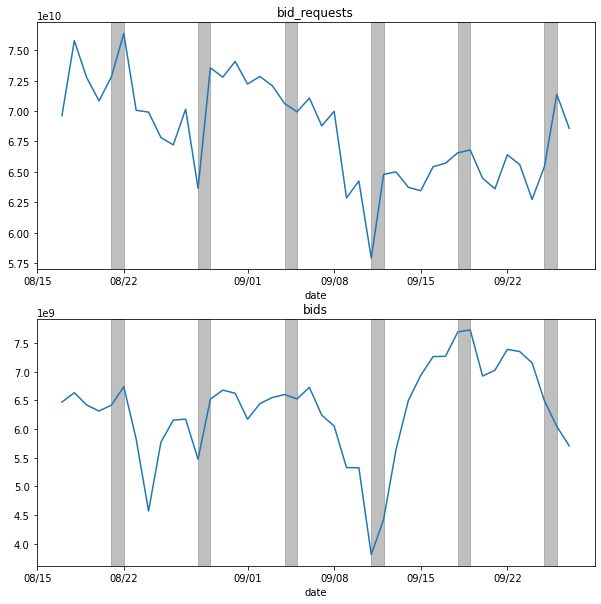

In [26]:
fig, ax = plt.subplots(2,1,figsize = (10,10))
pivot['bid_requests'].droplevel(1).plot(ax = ax[0])
ax[0].set_title('bid_requests')
ax[0].axvspan(datetime.date(2021,8,21),datetime.date(2021,8,22), color = 'grey', alpha = 0.5)
ax[0].axvspan(datetime.date(2021,8,28),datetime.date(2021,8,29), color = 'grey', alpha = 0.5)
ax[0].axvspan(datetime.date(2021,9,4),datetime.date(2021,9,5), color = 'grey', alpha = 0.5)
ax[0].axvspan(datetime.date(2021,9,11),datetime.date(2021,9,12), color = 'grey', alpha = 0.5)
ax[0].axvspan(datetime.date(2021,9,18),datetime.date(2021,9,19), color = 'grey', alpha = 0.5)
ax[0].axvspan(datetime.date(2021,9,25),datetime.date(2021,9,26), color = 'grey', alpha = 0.5)
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
pivot['bids'].droplevel(1).plot(ax = ax[1])
ax[1].set_title('bids')
ax[1].axvspan(datetime.date(2021,8,21),datetime.date(2021,8,22), color = 'grey', alpha = 0.5)
ax[1].axvspan(datetime.date(2021,8,28),datetime.date(2021,8,29), color = 'grey', alpha = 0.5)
ax[1].axvspan(datetime.date(2021,9,4),datetime.date(2021,9,5), color = 'grey', alpha = 0.5)
ax[1].axvspan(datetime.date(2021,9,11),datetime.date(2021,9,12), color = 'grey', alpha = 0.5)
ax[1].axvspan(datetime.date(2021,9,18),datetime.date(2021,9,19), color = 'grey', alpha = 0.5)
ax[1].axvspan(datetime.date(2021,9,25),datetime.date(2021,9,26), color = 'grey', alpha = 0.5)
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))

![alt text](files/Screen%20Shot%202021-09-14%20at%201.27.00%20PM.png "Title")

In [32]:
pvt = df.pivot_table(values = ['impressions','clicks','installs','revenue','cost'], index = ['dow'], aggfunc = np.sum)
pvt2 = df_auctions_bids.pivot_table(values = ['bids','bid_requests','bid_price'], index = ['dow'], aggfunc = np.sum)

pvt = pvt.join(pvt2)
format_pvt = calc_metrics3(pvt)
format_pvt.style.format(format_map).background_gradient(cmap = cm, subset = ['bid_rate','win_rate','ctr','ir','ipm','bpm','cpm','rpi','revenue_sov','cost_sov','margin'])

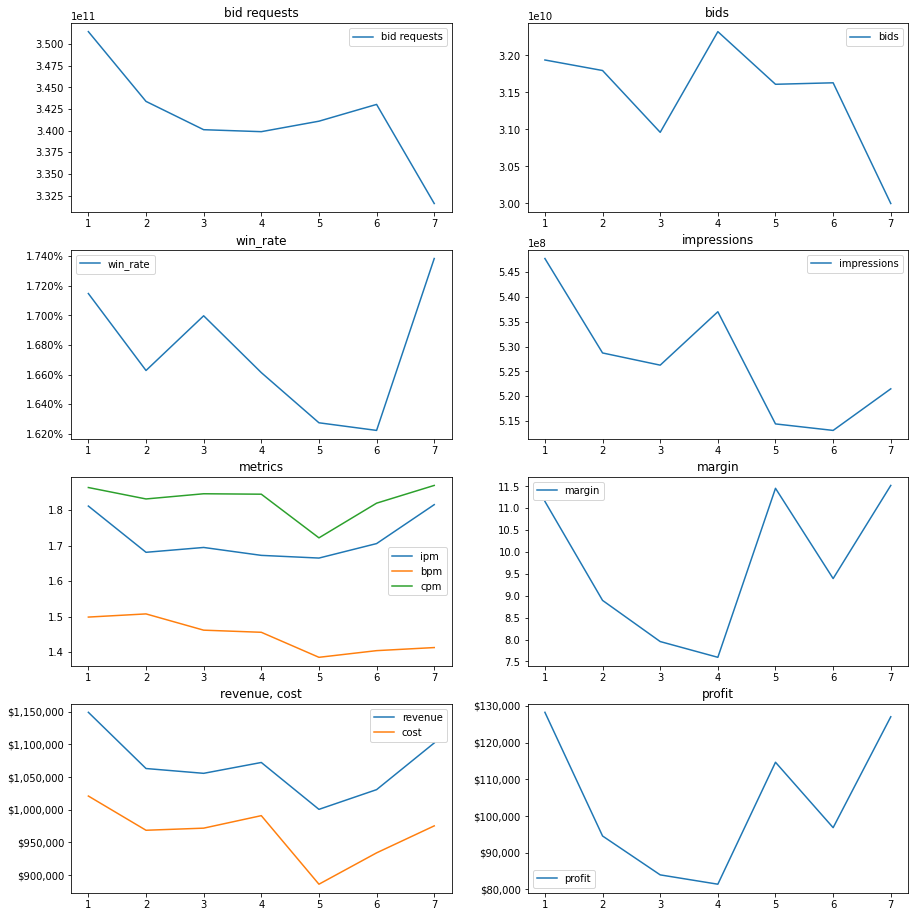

In [33]:
fig, ax = plt.subplots(4,2, figsize = (15,16))
ax[0,0].plot(format_pvt[['bid_requests']])
ax[0,0].legend(['bid requests'])
ax[0,0].set_title('bid requests')
ax[0,1].plot(format_pvt[['bids']])
ax[0,1].set_title('bids')
ax[0,1].legend(['bids'])
ax[1,0].plot(format_pvt[['win_rate']])
ax[1,0].set_title('win_rate')
ax[1,0].legend(['win_rate'])
ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
ax[1,1].plot(format_pvt[['impressions']])
ax[1,1].set_title('impressions')
ax[1,1].legend(['impressions'])
ax[2,0].plot(format_pvt[['ipm','bpm','cpm']])
ax[2,0].set_title('metrics')
ax[2,0].legend(['ipm','bpm','cpm'])
ax[2,1].plot(format_pvt[['margin']])
ax[2,1].set_title('margin')
ax[2,1].legend(['margin'])
ax[3,0].plot(format_pvt[['revenue','cost']])
ax[3,0].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[3,0].set_title('revenue, cost')
ax[3,0].legend(['revenue','cost'])
ax[3,1].plot(format_pvt[['profit']])
ax[3,1].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
ax[3,1].set_title('profit')
ax[3,1].legend(['profit'])

In [34]:
pvt = df.pivot_table(values = 'revenue', index = ['dow'], columns = 'edow', aggfunc = np.sum, margins = True)

pvt2 = 100*pvt.div(pvt.iloc[:,-1]).iloc[:-1,:-1]
pvt2.style.format('{:.0f}%').background_gradient(cmap=cm)

In [11]:
df_organic = bigquery_client.query(f"""
select
    date(t_created) as date
    , extract(dayofweek from date(t_created)) dow
    , bundle
    , count(*)*16 as installs
from external_data.ext_data
where 
    date(t_created) >= '{start_dt}'
    and date(t_created) <= '{end_dt}'
    and right(tid,1) = '0'
    and type = 'install'
group by 1,2,3
""").to_dataframe()
df_organic

date  dow                      bundle  installs
0      2021-08-19    5            com.mercadolibre    174256
1      2021-08-19    5       com.nexonm.bhgrts.adk        16
2      2021-08-19    5          com.myklarnamobile     14688
3      2021-08-19    5      air.com.beachbumgammon      2800
4      2021-08-19    5                  1560656677     19920
...           ...  ...                         ...       ...
16089  2021-09-22    4                  1462419002       112
16090  2021-09-22    4                  1247519638       704
16091  2021-09-22    4              com.amazon.mp3    310112
16092  2021-09-22    4                  1179213067      8784
16093  2021-09-22    4  com.nexonm.dominations.adk      3456

[16094 rows x 4 columns]

In [35]:
pivot = df_organic.pivot_table(values = ['installs'], index = 'dow', aggfunc = np.sum, margins = True)
sov_pivot = 100*pivot.div(pivot.iloc[-1]).iloc[:-1]
sov_pivot

installs
dow           
1    15.797355
2    14.794012
3    14.106815
4    14.257842
5    12.748983
6    13.426549
7    14.868445

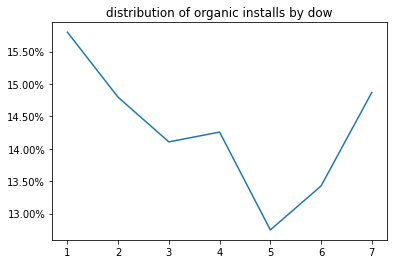

In [36]:
plt.plot(sov_pivot)
plt.title('distribution of organic installs by dow')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(100))

In [37]:
top_organic_bnds = df_organic.groupby('bundle')['installs'].sum().sort_values( ascending = False)[:100].index.tolist()

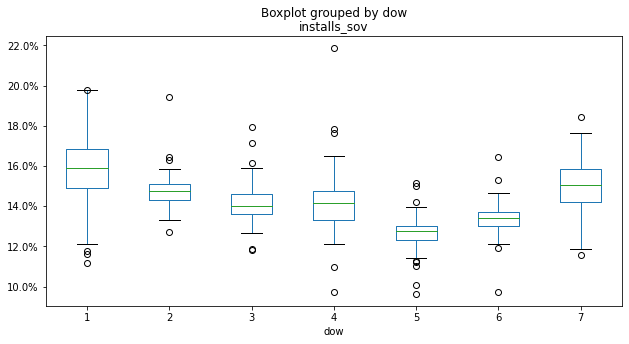

In [38]:
pvt = df_organic[df_organic.bundle.isin(top_organic_bnds)].pivot_table(values = 'installs', index = ['dow','bundle'], aggfunc = np.sum).reset_index()
pvt['installs_sov'] = pvt['installs']/pvt.groupby('bundle')['installs'].transform('sum')

pvt.boxplot(by = 'dow', column = 'installs_sov', grid = False, figsize = (10,5))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

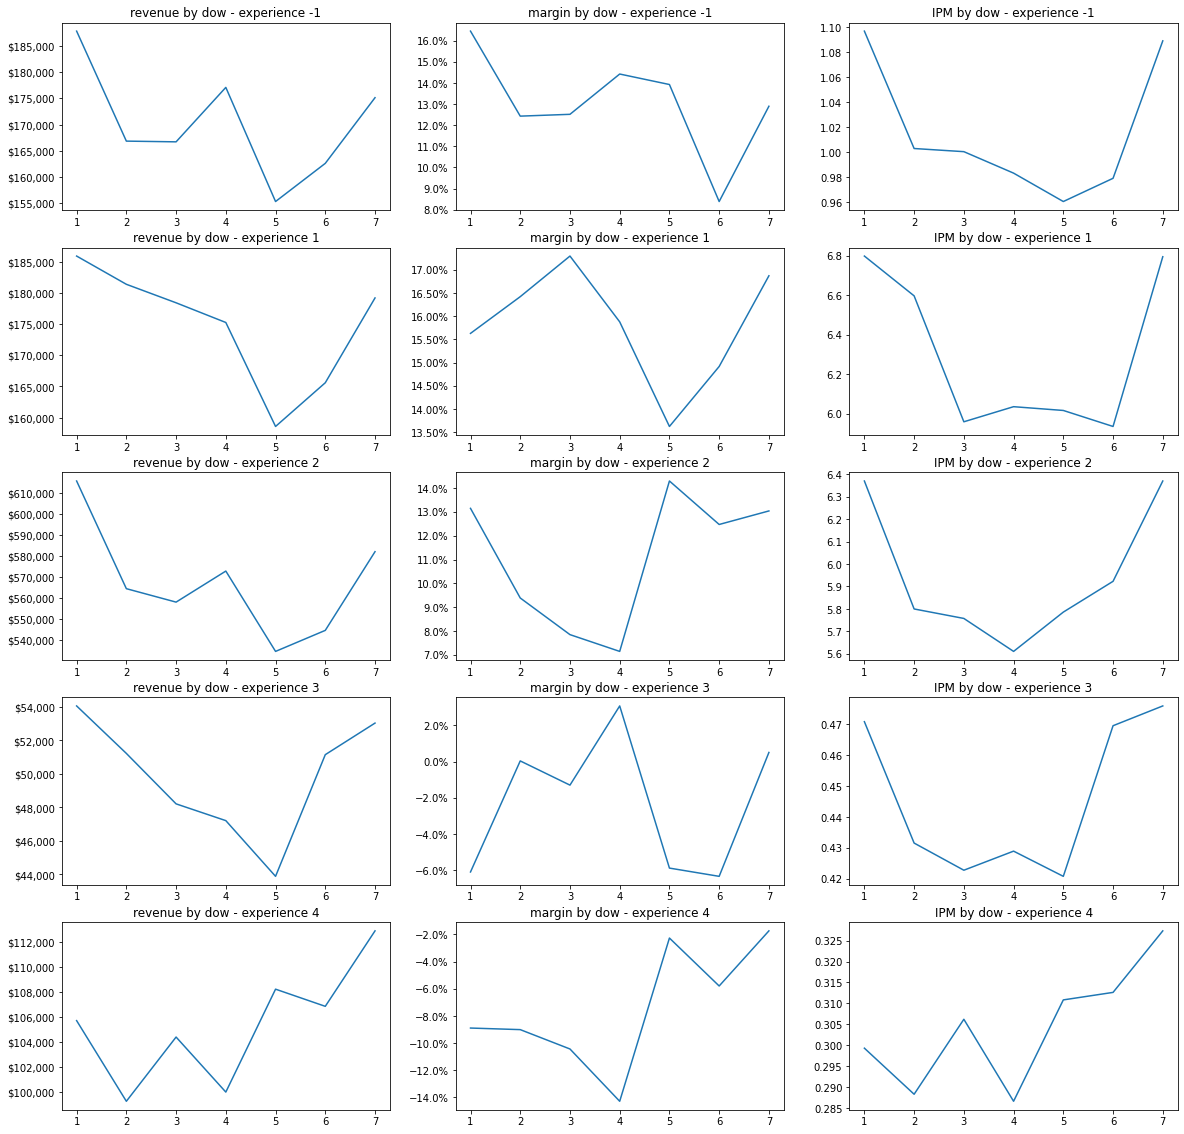

In [39]:
fig, ax = plt.subplots(5,3, figsize = (20,20))
exp_types = [-1,1,2,3,4]
for i in range(5):
    exp_type = exp_types[i]
    filters = (df.experience_type == exp_type) #& (df.campaign_name.isin(top_campaigns))
    pvt = df[filters].pivot_table(values = ['impressions','installs','revenue','cost'], index = ['dow'], aggfunc = np.sum)
    pvt['ipm'] = 1000*pvt['installs']/pvt['impressions']
    pvt['margin'] = 100*(pvt.revenue-pvt.cost)/pvt.revenue
#     pvt['revenue_sov'] = pvt['revenue']/pvt.groupby('campaign_name')['revenue'].transform('sum')
    
    ax[i,0].set_title(f'revenue by dow - experience {exp_type}')
    ax[i,0].plot(pvt['revenue'])
#     pvt.boxplot(by = 'dow', column = 'revenue_sov', grid = False, ax = ax[i,0])
    ax[i,0].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
    ax[i,1].set_title(f'margin by dow - experience {exp_type}')
    ax[i,1].plot(pvt['margin'])
#     pvt.boxplot(by = 'dow', column = 'margin', grid = False, ax = ax[i,1])
    ax[i,1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[i,2].set_title(f'IPM by dow - experience {exp_type}')
    ax[i,2].plot(pvt['ipm'])
#     pvt.boxplot(by = 'dow', column = 'ipm', grid = False, ax = ax[i,2])


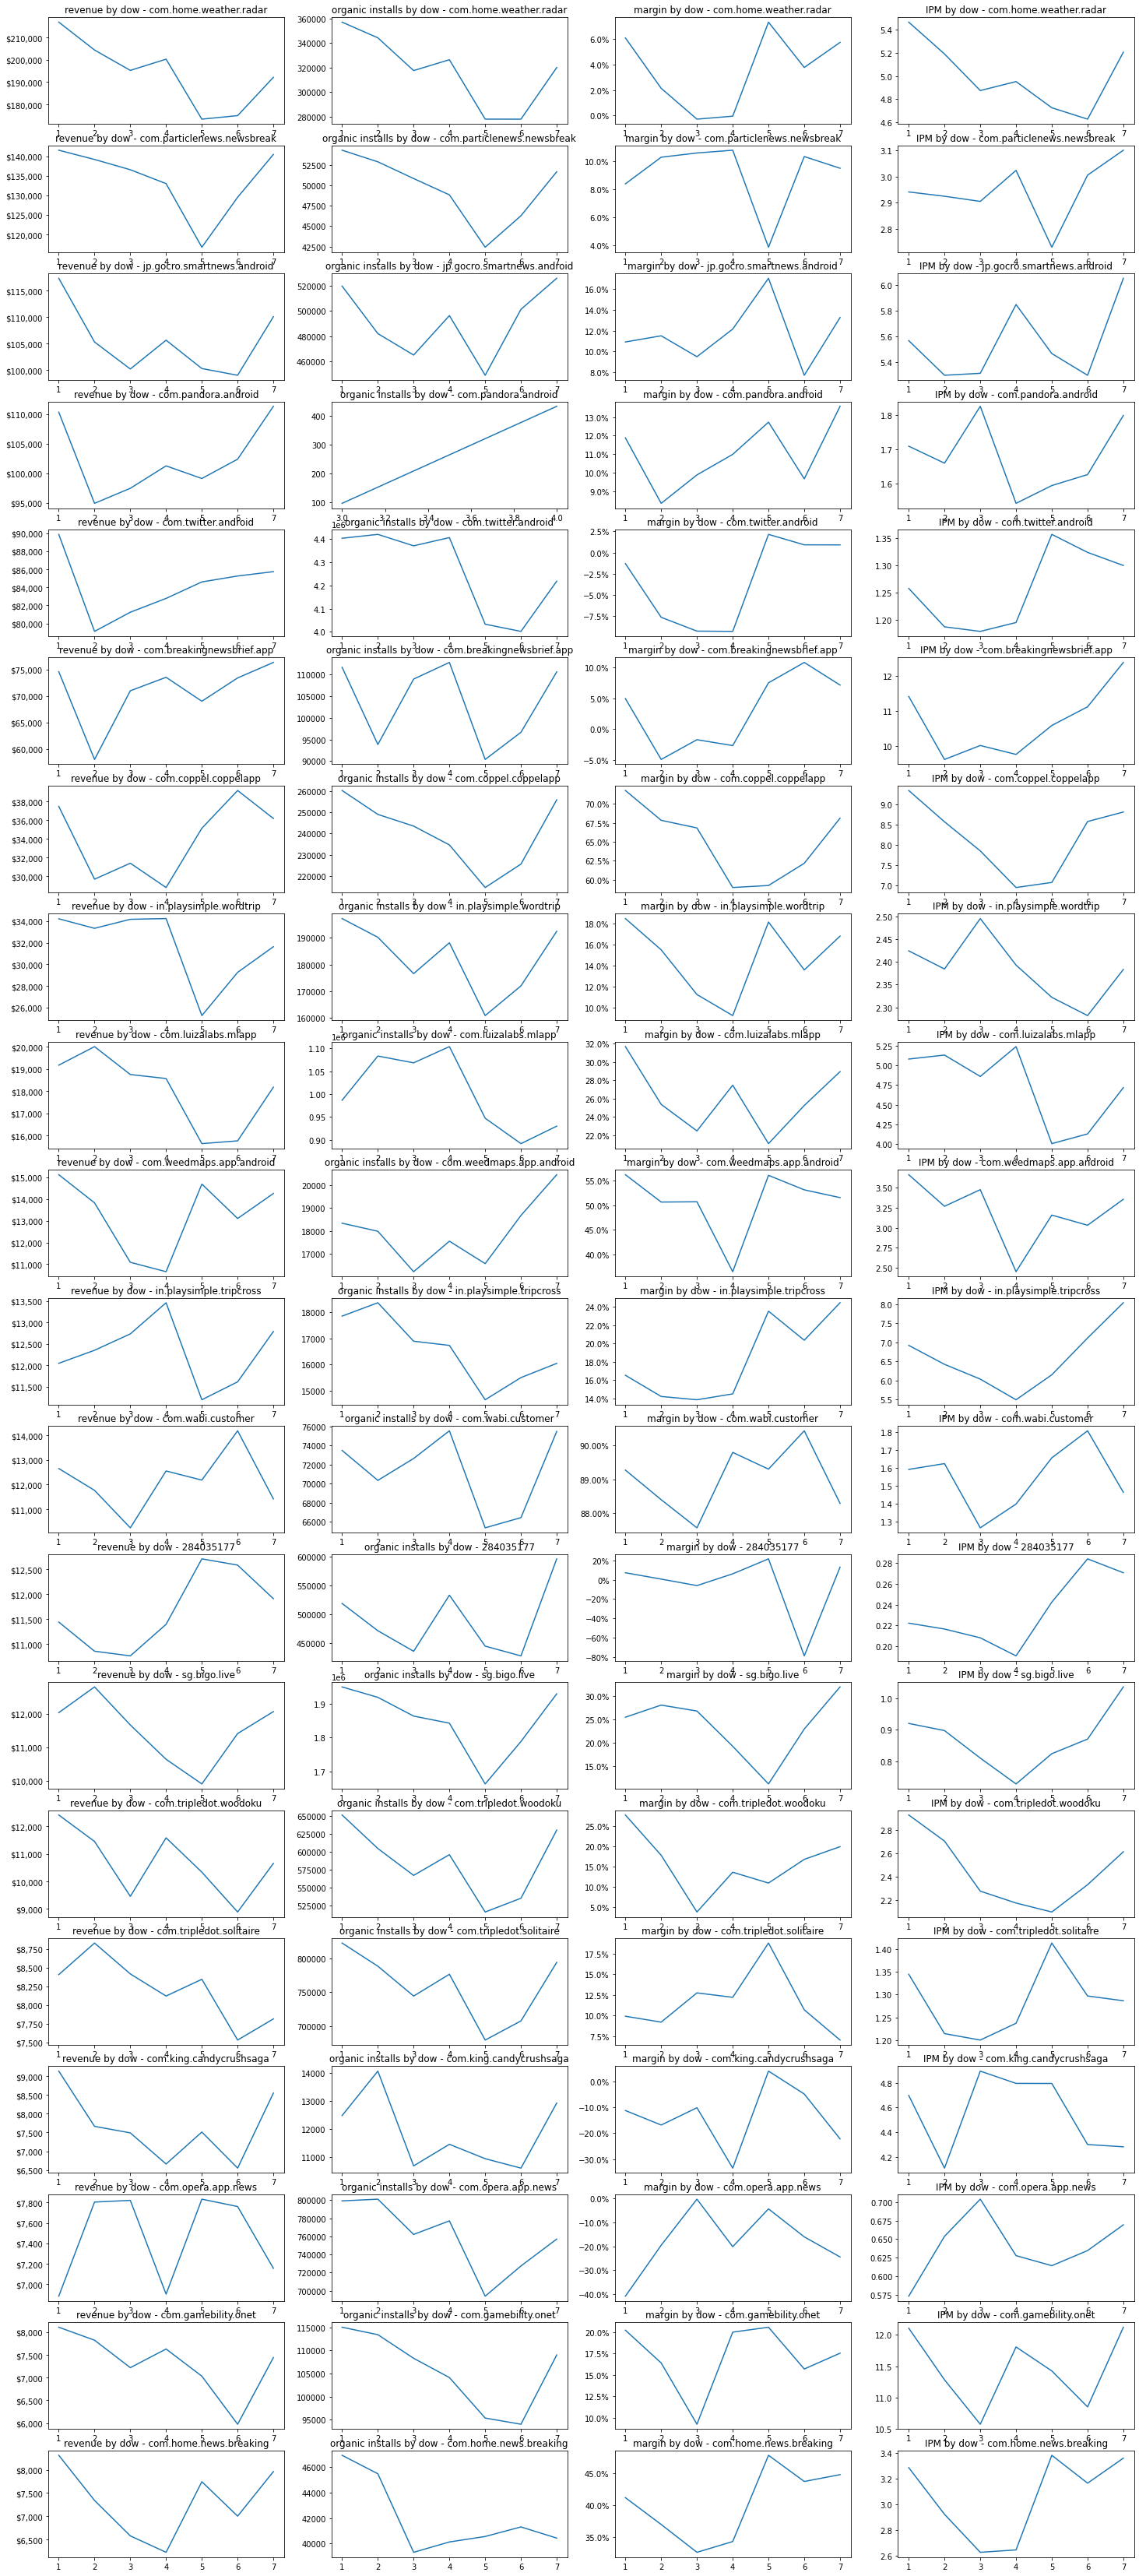

In [40]:
top_bnds = df.groupby('sponsored_bnd')['revenue'].sum().sort_values(ascending = False).index[:20]

fig, ax = plt.subplots(len(top_bnds),4, figsize = (25,3*len(top_bnds)))
for i in range(len(top_bnds[:20])):
    pvt = df[df.sponsored_bnd == top_bnds[i]].pivot_table(values = ['impressions','installs','revenue','cost'], index = ['dow'], aggfunc = np.sum)
    pvt['ipm'] = 1000*pvt['installs']/pvt['impressions']
    pvt['margin'] = 100*(pvt.revenue-pvt.cost)/pvt.revenue

    ax[i,0].set_title(f'revenue by dow - {top_bnds[i]}')
    ax[i,0].plot(pvt['revenue'])
    ax[i,0].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
    try:
        ax[i,1].plot(df_organic[df_organic.bundle == top_bnds[i]].pivot_table(values = 'installs', index = ['dow'], aggfunc = np.sum))
    except:
        print(f'no organic installs for {top_bnds[i]}')
    
    ax[i,1].set_title(f'organic installs by dow - {top_bnds[i]}')
    ax[i,2].set_title(f'margin by dow - {top_bnds[i]}')
    ax[i,2].plot(pvt['margin'])
    ax[i,2].yaxis.set_major_formatter(mtick.PercentFormatter(100))

    ax[i,3].set_title(f'IPM by dow - {top_bnds[i]}')
    ax[i,3].plot(pvt['ipm'])

    

In [41]:
by_campaign_day = df[(df.cost > 0) | (df.revenue > 0)].pivot_table(values = ['cost','installs','revenue','hour']
                                 , index = ['campaign_name','ssb_campaign_uuid','edate','dow']
                                , aggfunc = {'cost':np.sum,'installs':np.sum,'revenue':np.sum, 'hour':max}).reset_index()
df_capping = pd.merge(by_campaign_day, df_campaigns_offers[['ssb_campaign_uuid','media_plan_daily_budget','mp_daily_installs','clm_max_loss']], on = 'ssb_campaign_uuid', how = 'left')
df_capping['budget_cap'] = np.where((df_capping.hour < 23) & (((df_capping.cost*1.25)>df_capping.media_plan_daily_budget)|(df_capping.installs>df_capping.mp_daily_installs)), True, False)
df_capping['loss_cap'] = np.where((df_capping.hour < 23) & (df_capping.revenue - df_capping.cost)<=(.95*df_capping.clm_max_loss), True, False)

In [42]:
# project out remaining budget based on the day's spend and remaining number of hours
df_capping['remaining_revenue'] = np.where(df_capping.budget_cap, df_capping.revenue * ((23 - df_capping.hour)/(df_capping.hour+1)), 0)
df_capping.remaining_revenue = df_capping.remaining_revenue.fillna(0)

<AxesSubplot:title={'center':'Number of campaigns cost or install capping by dow'}, xlabel='dow'>

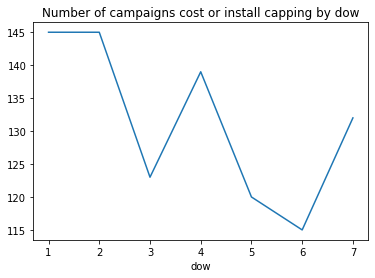

In [43]:
df_capping[df_capping.budget_cap].pivot_table(values = ['edate'], index = 'ssb_campaign_uuid', columns = ['dow'], aggfunc = lambda x:len(x.unique())).sum(axis=0).droplevel(0).plot(title = 'Number of campaigns cost or install capping by dow')

In [44]:
remaining_rev_df = (1/wks)*df_capping.pivot_table(values = ['remaining_revenue'], index = 'dow', aggfunc = np.sum)
remaining_rev_df.style.format('${:,.0f}')

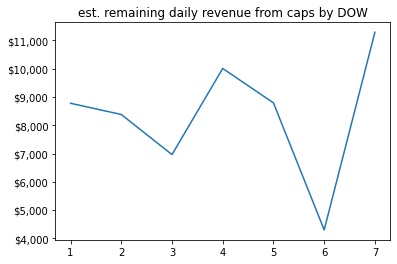

In [45]:

plt.title('est. remaining daily revenue from caps by DOW')
plt.plot(remaining_rev_df)
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

In [46]:
top_remaining = 1/wks * df_capping.pivot_table(values = 'remaining_revenue', index = ['campaign_name','ssb_campaign_uuid'], columns = 'dow', aggfunc = sum)
top_remaining['weekend remaining rev'] = top_remaining[1]+top_remaining[7]
top_remaining.sort_values('weekend remaining rev', ascending = False, inplace = True)
top_remaining.head(20).style.format('${:,.0f}').background_gradient(cmap=cm)

In [47]:
top_remaining.sum()

dow
1                         8776.897780
2                         8380.503701
3                         6962.662522
4                        10007.411640
5                         8790.536784
6                         4301.292074
7                        11286.877026
weekend remaining rev    20063.774806
dtype: float64

# When did we hit max hourly budget of 22k?

Text(0.5, 1.0, 'hourly exchange cost distribution')

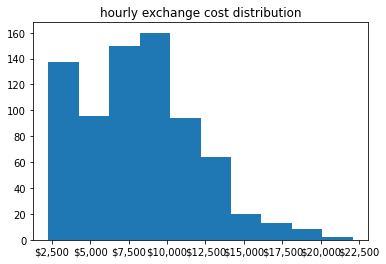

In [48]:
by_date_hour = df[df.date >= pd.to_datetime(end_dt) - datetime.timedelta(days=30)].groupby(['date','hour'])['cost'].sum().to_frame()
plt.hist(by_date_hour.cost)
plt.gca().xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.title('hourly exchange cost distribution')

In [49]:
by_date_hour.sort_values('cost',ascending = False)

cost
date       hour              
2021-09-03 23    22085.545941
2021-09-21 1     20233.530292
2021-09-18 2     19956.533255
           1     19761.462495
2021-09-17 1     18958.142024
...                       ...
2021-08-31 8      2421.711785
2021-09-06 9      2419.012474
2021-09-02 8      2359.058402
2021-08-25 8      2336.036653
2021-08-23 8      2284.120641

[744 rows x 1 columns]

Checking recent


In [ ]:
df_auctions_bids2 = bigquery_client.query(f"""
select
    date(r.t_created) as date
    , extract(dayofweek from date(r.t_created)) as dow
    , r.exchange_id
    , sum(if(event_type = 'auction',1,0))*512 bid_requests
    , sum(if(event_type = 'bid',1,0))*32 bids
    , sum(if(event_type = 'bid',bid_price,0))/1000*32 as bid_price
from stats.auctions_bids r 
left join metadata.campaigns c 
    on r.ssb_campaign_uuid = c.uuid
left join metadata.apps sp
    on r.sponsored_app_id = sp.app_id
left join metadata.apps ho
    on r.hosting_app_id = ho.app_id
where 
    date(r.t_created) >= '2021-09-15'
    and date(r.t_created) <= '2021-09-21'
group by 1,2,3
""").to_dataframe()
df_auctions_bids2 = df_auctions_bids2.set_index('exchange_id').join(exchange.set_index('exchange_id')).reset_index()

In [ ]:
top_exchanges = df_auctions_bids2.groupby('exchange_name')['bid_price'].sum().sort_values(ascending = False).index[:10].tolist()
pvt = df_auctions_bids2[df_auctions_bids2.exchange_name.isin(top_exchanges)].pivot_table(values = ['bid_requests','bids'], columns = ['exchange_name'], index = ['dow'], aggfunc = np.sum, margins = True)
pvt = pvt.loc[:,pvt.columns[pvt.columns.get_level_values(1) != 'All']]

sov_pvt = 100*pvt.div(pvt.iloc[-1]).iloc[:-1,:-1]
sov_pvt

In [ ]:
fig, ax = plt.subplots(5,1,figsize = (15,23))
sov_pvt['bid_requests'].plot(title = 'bid requests sov by exchange', ax = ax[0], figure = fig)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
sov_pvt['bids'].plot(title = 'bids sov by exchange', ax = ax[1], figure = fig)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(100))

for x in top_exchanges:
    pvt[('bid_rate', x)] = 100*pvt[('bids',x)]/pvt['bid_requests',x]
pvt.loc[:7,'bid_rate'].plot(title = 'bid_rate by exchange', ax = ax[2], figure = fig)
ax[2].yaxis.set_major_formatter(mtick.PercentFormatter(100))

# searching for specific examples

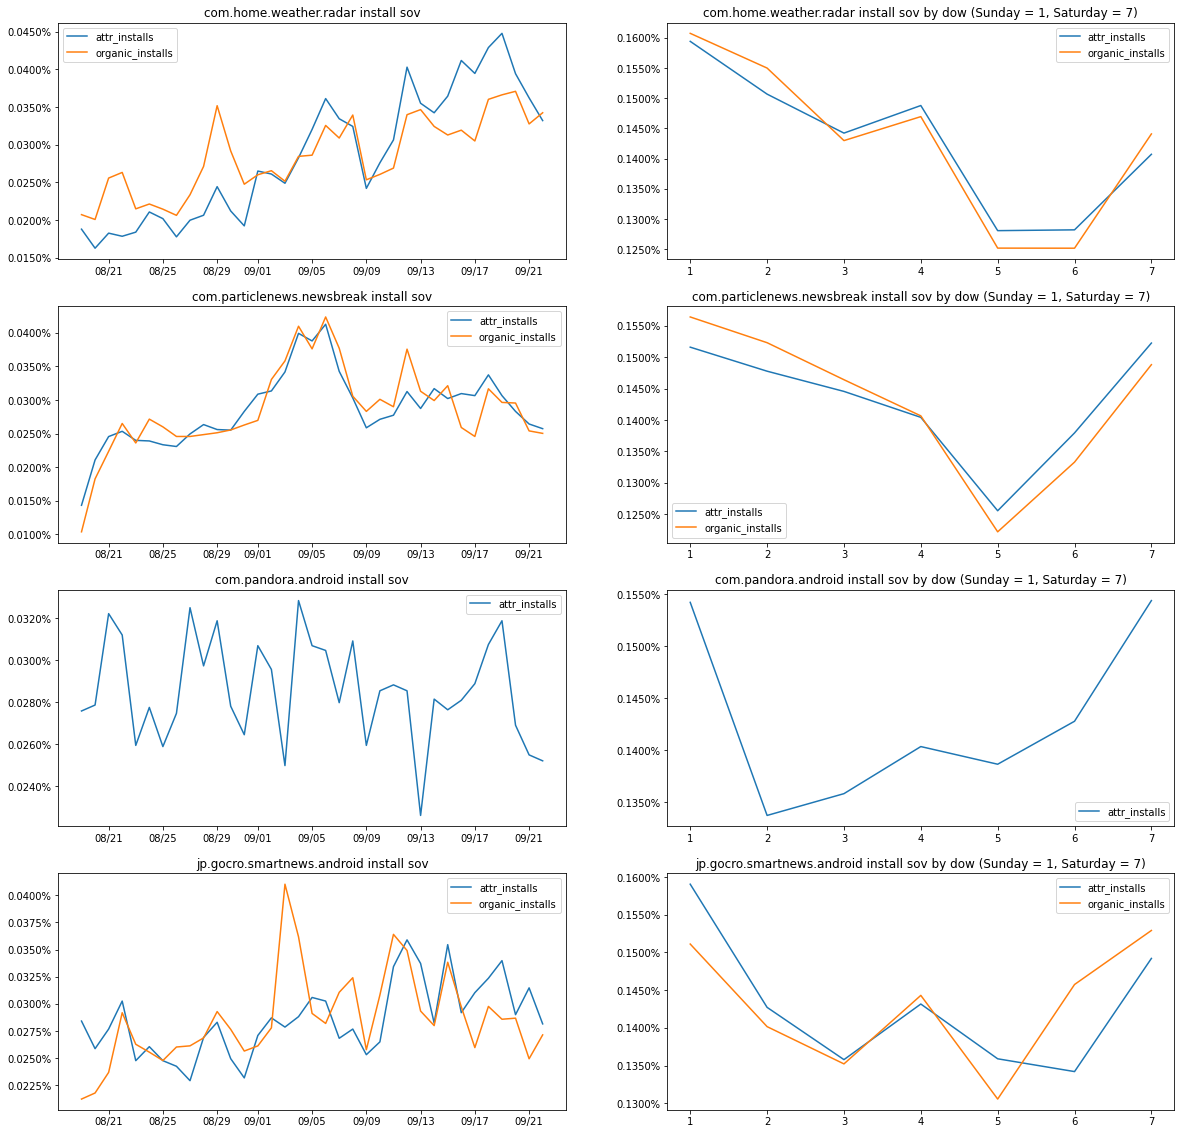

In [26]:
fig, ax = plt.subplots(4,2, figsize = (20,20))
bundles = ['com.home.weather.radar','com.particlenews.newsbreak','com.pandora.android','jp.gocro.smartnews.android']
for i in range(4):
    bnd = bundles[i]
    
    attr_pivot = df[df.sponsored_bnd == bnd].pivot_table(values = 'installs', index = 'date', aggfunc = np.sum, margins = True)
    attr_sov_pivot = attr_pivot.div(attr_pivot.iloc[-1]).iloc[:-1]
    organic_pivot = df_organic[df_organic.bundle == bnd].pivot_table(values = 'installs', index = 'date', aggfunc = np.sum, margins = True)
    organic_sov_pivot = organic_pivot.div(organic_pivot.iloc[-1]).iloc[:-1]
    
    ax[i,0].plot(attr_sov_pivot)
    ax[i,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax[i,0].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[i,0].set_title(f'{bnd} install sov')
    if bnd != 'com.pandora.android':
        ax[i,0].plot(organic_sov_pivot)
    ax[i,0].legend(['attr_installs','organic_installs'])
    
    attr_dow_pivot = df[df.sponsored_bnd == bnd].pivot_table(values = 'installs', index = 'dow', aggfunc = np.sum, margins = True)
    attr_dow_sov_pivot = attr_dow_pivot.div(attr_dow_pivot.iloc[-1]).iloc[:-1]
    organic_dow_pivot = df_organic[df_organic.bundle == bnd].pivot_table(values = 'installs', index = 'dow', aggfunc = np.sum, margins = True)
    organic_dow_sov_pivot = organic_dow_pivot.div(organic_dow_pivot.iloc[-1]).iloc[:-1]
    
    ax[i,1].plot(attr_dow_sov_pivot)
    ax[i,1].yaxis.set_major_formatter(mtick.PercentFormatter(100))
    ax[i,1].set_title(f'{bnd} install sov by dow (Sunday = 1, Saturday = 7)')
    if bnd != 'com.pandora.android':
        ax[i,1].plot(organic_dow_sov_pivot)
    ax[i,1].legend(['attr_installs','organic_installs'])

In [17]:
df_organic[df_organic.bundle == 'com.pandora.android']

date  dow               bundle  installs
15362  2021-09-21    3  com.pandora.android        96
15846  2021-09-22    4  com.pandora.android       432